In [14]:
%load_ext autoreload
%autoreload 1

import segmentation_models_pytorch as smp
from PIL import Image
import os
from pathlib import Path
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

%aimport DataScienceBowl
from DataScienceBowl import DataScienceBowl
%aimport Trainer
from Trainer import Trainer
%aimport CustomUnet
from CustomUnet import CustomUnet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Set device to GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('using cuda')
else:
    torch.device('cpu')
    print('using cpu')
    
# Set seeds
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

using cuda


In [3]:
class DecoderIdentity(torch.nn.Identity):
    def __init__(self, *args, **kwargs):
        super(DecoderIdentity, self).__init__(*args, **kwargs)
        
    def forward(self, x, skip=None):
#         print('x', x.shape)
#         print('s', skip.shape)
#         if skip is not None:
#             x = torch.cat([x, skip], dim=1)
            
        return x
    
class CustomIdentity(torch.nn.Identity):
    
    def forward(self, x):
#         print(x.shape)
        return super().forward(x)

In [16]:
# Load UNet Model
# model = smp.Unet(
#     encoder_name="resnet18",
#     encoder_weights="imagenet",
# #     encoder_depth=3,
# #     decoder_channels=(64, 32, 16),
#     in_channels=3,
#     classes=1,
# )

model = CustomUnet()

model.to(device)

[autoreload of CustomUnet failed: Traceback (most recent call last):
  File "C:\Users\Harm\.conda\envs\thesis\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Harm\.conda\envs\thesis\lib\site-packages\IPython\extensions\autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\Harm\.conda\envs\thesis\lib\site-packages\IPython\extensions\autoreload.py", line 347, in update_generic
    update(a, b)
  File "C:\Users\Harm\.conda\envs\thesis\lib\site-packages\IPython\extensions\autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "C:\Users\Harm\.conda\envs\thesis\lib\site-packages\IPython\extensions\autoreload.py", line 347, in update_generic
    update(a, b)
  File "C:\Users\Harm\.conda\envs\thesis\lib\site-packages\IPython\extensions\autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
Val

AttributeError: cannot assign module before Module.__init__() call

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
count_parameters(model)
# count_parameters(model.encoder.layer4)
# count_parameters(model.decoder.blocks[0])
# model

3574161

In [11]:
model.encoder.layer4 = torch.nn.Identity()
model.decoder.blocks[0] = DecoderIdentity()

# model.decoder.center = CustomIdentity()

In [13]:
# Define Transforms
# TODO Separate Train and Test transforms
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
#     T.ToTensor()
#     T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [14]:
# Load data and split into train and test
dataset = DataScienceBowl('data/data_science_train', transform=transform)

indices = torch.randperm(len(dataset)).tolist()

train_dataset = torch.utils.data.Subset(dataset, indices[:-100])
validation_dataset = torch.utils.data.Subset(dataset, indices[-100:-50])
test_dataset = torch.utils.data.Subset(dataset, indices[-50:])

# MINI SET
# train_dataset = torch.utils.data.Subset(dataset, indices[:50])
# validation_dataset = torch.utils.data.Subset(dataset, indices[-60:-10])
# test_dataset = torch.utils.data.Subset(dataset, indices[-10:])


dataLoader_training = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
dataLoader_validation = DataLoader(dataset=validation_dataset, batch_size=8, shuffle=True)

dataLoader_test = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

In [ ]:
# Use Binary Cross Entropy Loss and Stochastic Gradient Descent
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

trainer = Trainer(model=model,
                 device=device,
                 criterion=criterion,
                 optimizer=optimizer,
                 training_DataLoader=dataLoader_training,
                 validation_DataLoader=dataLoader_validation,
                 test_DataLoader=dataLoader_test,
                 epochs=20,
                 notebook=True)

train_loss, val_loss, lr, test_loss, test_iou = trainer.run_trainer()



Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

In [19]:
torch.save(model.state_dict(), 'Smol_UNet_pretrained_20epochs.pt')

In [13]:
print(test_loss, test_iou)

0.112164770886302 0.6786456670672224


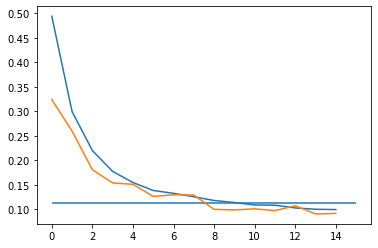

In [14]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.hlines(test_loss, 0, 15)
plt.show()

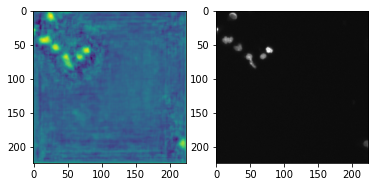

In [17]:
sample = train_dataset[0]
img, target = sample.values()
model.eval()
out = model(img.unsqueeze(0).to(device))

# print(out)

f,a = plt.subplots(1,2)

a[0].imshow(out.squeeze(0).permute(1,2,0).detach().cpu().numpy())
a[1].imshow(img.permute(1,2,0)/255)
plt.show()


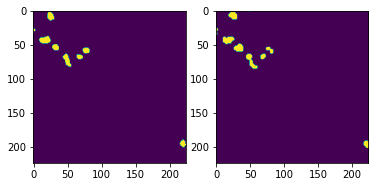

In [18]:
import torch.nn.functional as F

mask = F.sigmoid(out) > 0.5

mask = mask.squeeze(0).squeeze(0).detach().cpu().numpy()

target = target.squeeze(0).type(torch.BoolTensor).detach().numpy()

f, a = plt.subplots(1,2)

a[0].imshow(mask)
a[1].imshow(target)

# plt.imshow(mask)
plt.show()

In [17]:
# IoU
from sklearn.metrics import jaccard_score

print(np.unique(mask.astype('int')))
print(np.unique(target.astype('int')))
# print(np.unique(target))

jaccard_score(mask.reshape(-1), target.reshape(-1))

[0 1]
[0 1]


0.4957780458383595

In [18]:
test_iou

0.6653905689472833